## import

In [78]:
seed = 42

# Import libraries
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(seed)
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import mutual_info_classif, SelectKBest, SelectPercentile, f_classif, f_regression, SelectFromModel
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
import statistics

sc = StandardScaler()
import pickle

## caricamento dati

### caricamento labels pazienti

In [129]:

file_path = "../CSV/data_rad_clin_DEF.csv"

data = pd.read_csv(file_path)
labels_column = data['label']
labels = labels_column.astype(int).tolist()

labels=np.array(labels)

# Estrazione dei numeri dai nomi dei pazienti
loaded_patients = data['IDs_new'].str.extract(r'(\d+)').astype(int).squeeze().tolist()

print("Labels:", labels)
print("Number of labels:", len(labels))
print("Patient Names: ", loaded_patients )




Labels: [0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0
 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0
 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1]
Number of labels: 129
Patient Names:  [5, 12, 15, 16, 17, 19, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 64, 65, 68, 69, 70, 71, 74, 75, 76, 78, 79, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 126, 127, 128, 129, 133, 135, 136, 137, 138, 139, 141, 142, 144, 146, 147, 149, 150, 153, 155, 158, 159, 161, 163, 166, 168, 169, 170, 171, 175, 176, 178, 182, 183, 188, 189, 190, 193, 197, 199, 200, 205]


### caricamento features autoencoder

In [ ]:

file_path = "../CSV/Features_VGG16.csv"
df = pd.read_csv(file_path, sep=',')


df['Unnamed: 0'] = df['Unnamed: 0'].astype(int)

df_ordered = df.set_index('Unnamed: 0').loc[loaded_patients].reset_index()

df_features = df_ordered.drop(columns=['Unnamed: 0'])

features = df_features.to_numpy()

print(features)
print(features.shape)


### caricamento features radiomica

In [130]:

file_path="../CSV/Radiomica_3D.csv"
df = pd.read_csv(file_path, sep=';')
df = df.astype(float)

# Colonne da rimuovere SOLO PER RADIOMICA
columns_to_remove = [
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'diagnostics_Image-original_Maximum',
    'diagnostics_Mask-original_VoxelNum',
    'diagnostics_Mask-original_VolumeNum',
]

df_cleaned = df.drop(columns=columns_to_remove)
df_features = df_cleaned.drop(columns=['Paziente'])

features = df_features.to_numpy()

print(features)
print(features.shape)  


[[6.42638351e-01 4.34811323e-01 1.16096656e+01 ... 2.69972505e+03
  2.80963106e-02 1.00514866e+01]
 [6.29082835e-01 5.34401455e-01 1.06699125e+01 ... 5.06730171e+03
  4.13964322e-02 9.21642811e+00]
 [5.33839928e-01 4.15372150e-01 1.11671922e+01 ... 3.95715175e+03
  1.13273940e-02 2.75076797e+01]
 ...
 [4.66390756e-01 3.69394607e-01 1.32282545e+01 ... 1.36263582e+02
  6.99679621e-02 4.97074683e-01]
 [4.14375204e-01 3.85297007e-01 1.19250944e+01 ... 8.96173941e+03
  5.69615647e-02 1.52012405e+01]
 [4.85039433e-01 3.32916705e-01 9.71060636e+00 ... 4.02397749e+03
  7.17804108e-02 4.97083572e+00]]
(129, 107)


## funzioni

In [131]:

## Rimozione feature correlation
def remove_highly_correlated_features(X, threshold=0.85):
    corr_matrix = np.corrcoef(X, rowvar=False)
    upper_triangle = np.triu(corr_matrix, k=1)
    to_drop = [column for column in range(upper_triangle.shape[0]) if any(abs(upper_triangle[column, :]) > threshold)]
    X_reduced = np.delete(X, to_drop, axis=1)
    return X_reduced, to_drop

## Rimozione features p_value
def remove_high_pvalue_features(X, y, alpha=0.05):
    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(X, y)
    p_values = selector.pvalues_
    features_to_keep = np.where(p_values < alpha)[0]
    X_reduced = X[:, features_to_keep]
    return X_reduced, features_to_keep

## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefficients = lasso.coef_
    selected_features = np.where(coefficients != 0)[0]
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FEATURE SELECTION MRMR
def mrmr_feature_selection(X, y, num_features):
    mi = mutual_info_classif(X, y)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    distances = squareform(pdist(X_scaled.T, 'euclidean'))
    
    selected_features = []
    selected_indices = []

    first_feature_index = np.argmax(mi)
    selected_features.append(first_feature_index)
    selected_indices.append(first_feature_index)
    
    for _ in range(num_features - 1):
        max_relevance = -np.inf
        selected_feature_index = -1
        
        for i in range(X.shape[1]):
            if i in selected_indices:
                continue
            
            relevance = mi[i]
            redundancy = np.mean(distances[i, selected_indices])
            
            mrmr_score = relevance - redundancy
            
            if mrmr_score > max_relevance:
                max_relevance = mrmr_score
                selected_feature_index = i
        
        selected_features.append(selected_feature_index)
        selected_indices.append(selected_feature_index)

    X_selected = X[:, selected_indices]
    return X_selected, selected_indices

## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    feature_importances = rf.feature_importances_
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features


## FEATURE SELECTION P_VALUE
# Seleziona e ordina le feature basate sui p-value con un test t di Student poi 
# ordina le feature in base al p-value in ordine crescente e seleziona le prime `num_features` caratteristiche.

def select_features_by_p_value(x_train_expanded, y_train_expanded, num_features):
    p_values = []
    num_features_total = x_train_expanded.shape[1]

    # Calcolo dei p-value per ciascuna feature
    for i in range(num_features_total):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)


    p_values = np.array(p_values)

    # Ordinare tutte le caratteristiche in base ai p-value (dal più piccolo al più grande)
    sorted_indices = np.argsort(p_values)
    sorted_indices = sorted_indices[:num_features]

    x_train_selected = x_train_expanded[:, sorted_indices]

    return x_train_selected, sorted_indices



## FUNZIONE PER RIMUOVERE FEATURES SELEZIONATE
def filter_patients_features(filtered_patients, selected_features):
    filtered_patients_selected = []

    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected



## FUNZIONE DI CLASSIFICAZIONE
def classification_method(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, mode="Val", selected_features=[0], thresholds=np.arange(0.4, 0.6, 0.01)):
    best_f1_score = 0
    best_case = None

    if mode == "Val":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection

        number_features = len(selected_features)  # Numero di feature selezionate

        # Training del classificatore
        classifier.fit(X_selected, y_train_expanded)


    if (mode == "Test"): ## non addestra il classificatore e non fa feature selection
        x_test = x_test[:, selected_features]
        number_features = len(selected_features)
    

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

    if(isinstance(thresholds, np.ndarray)== False): ## se la threshold viene data fissa
        thresholds=[thresholds]
        
    
    for threshold in thresholds:

            y_pred_custom_test = (y_proba_test >= threshold).astype(int)

            accuracy = accuracy_score(y_test, y_pred_custom_test)
            f1 = f1_score(y_test, y_pred_custom_test)
            roc_auc = roc_auc_score(y_test, y_proba_test)

            precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
            pr_auc = auc(recall, precision)

            best_precision = precision[np.argmax(recall)]
            best_recall = recall[np.argmax(recall)]

            conf = confusion_matrix(y_test, y_pred_custom_test)

            # Se il nuovo risultato è migliore rispetto al migliore attuale (in base all'f1 e altrimenti pr_auc)
            if f1 > best_f1_score or (f1 == best_f1_score and pr_auc > (best_case['pr_auc'] if best_case else 0)):
                best_f1_score = f1
                best_case = {
                    'alpha': alpha,
                    'num_features': number_features,
                    'selected_features': selected_features,
                    'pr_auc': pr_auc,
                    'best_precision': best_precision,
                    'best_recall': best_recall,
                    'roc_auc': roc_auc,
                    'f1': f1,
                    'accuracy': accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': threshold
                }

    return best_case



## split

In [132]:
#y_train1, y_test, x_train1, X_test= train_test_split(Y_train, x_train, test_size=0.2, shuffle=False, random_state=1)
#y_train, y_val, X_train, X_val= train_test_split(y_train1, x_train1, test_size=0.3, shuffle=True, stratify=y_train1, random_state=2)
#y_train, y_val, X_train, X_val= train_test_split(y_train1, x_train1, test_size=0.3, shuffle=False, random_state=7)

Y_train, y_test, X_train, X_test= train_test_split(labels, features, test_size=0.2, shuffle=False, random_state=1)

## correlation e p_value

In [133]:

## FEATURE CORRELATION

X_train_reduced, dropped_features = remove_highly_correlated_features(X_train, 0.8)
#X_val_reduced = np.delete(X_val, dropped_features, axis=1)
X_test_reduced = np.delete(X_test, dropped_features, axis=1)

#print(X_train_reduced.shape)
#print(X_test_reduced.shape)
#print(X_val_reduced.shape)

# RIMOZIONE FEATURES CON P_VALUE ELEVATO

#X_train_reduced, features_to_keep = remove_high_pvalue_features(X_train, Y_train, alpha=0.05)
#X_val_reduced = X_val_reduced[:, features_to_keep]
#X_test_reduced = X_test[:, features_to_keep]


print(X_train_reduced.shape)
print(X_test_reduced.shape)
#print(X_val_reduced.shape)

(103, 22)
(26, 22)


## parametri

In [134]:
alpha_values = np.linspace(0, 0.006, 30).tolist()

thresholds=np.arange(0.4, 0.6, 0.001) 


#selectors=['p_value', 'mrmr','rf', 'logistic', 'lasso']
selectors=['p_value', 'mrmr','rf', 'logistic']

classifiers=['XgBoost',  'SVM', 'ensemble','RandomForest', 'Logistic', 'MLP']
#classifiers = ['MLP']

## loop cross val

In [ ]:
n_folds=5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

#scores = []
template_dict = {
                'fold': None,
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'best_precision': None,
                'best_recall': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'best_threshold': None,
                'selected_features': []
            }

## creazione di dizionari vuoti (range con numero elevato casuale)
results_val = [template_dict.copy() for _ in range(900000)]
results_val.append(template_dict.copy())


k=0
for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train_reduced, Y_train)):
    print("Starting with fold:", fold_idx)

    x_train_reduced, X_val_reduced = X_train_reduced[train_index], X_train_reduced[val_index]
    y_train, y_val = Y_train[train_index], Y_train[val_index]

    for i, classifier in enumerate(classifiers):
        print("Starting with classifier:", classifier)
        for j, selector in enumerate(selectors):
            print("Starting with selector:", selector)

            best_f1 = 0
            best_case = None

            if(selector=='lasso'):
                for alpha in alpha_values:

                    if classifier == 'RandomForest':
                        classi = RandomForestClassifier(n_estimators=100, random_state=42)
                        #selector_rf = SelectFromModel(classi, threshold='mean')
                        #X_train_rf = selector_rf.fit_transform(x_train_reduced, y_train)
                        #X_test_rf = selector_rf.transform(X_test_reduced)
                        #X_val_rf = selector_rf.transform(X_val_reduced)
                        #if(t>len(X_train_rf[0])):
                        #   continue

                    elif classifier == 'Logistic':
                        classi = LogisticRegression()
                        #selector_lr = SelectFromModel(classi, threshold='mean')
                        #X_train_lr = selector_lr.fit_transform(x_train_reduced, y_train)
                        #X_test_lr = selector_lr.transform(X_test_reduced)
                        #X_val_lr = selector_lr.transform(X_val_reduced)
                        #if(t>len(X_train_lr[0])):
                        #    continue
                    
                    elif classifier == 'SVM':
                        classi = SVC(kernel='rbf', probability=True, random_state=42)
                    elif classifier == 'XgBoost':
                        classi = XGBClassifier()
                    elif classifier == 'MLP':
                        classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                    elif classifier == 'ensemble':
                        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                        logistic_model = LogisticRegression(random_state=42)
                        svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                        classi = VotingClassifier(
                            estimators=[
                                ('random_forest', rf_model),
                                ('logistic', logistic_model),
                                ('svc', svc_model)
                            ],
                            voting='soft'
                            )

                    best_case = classification_method(selector, classi, alpha, x_train_reduced, y_train, X_val_reduced, y_val, num_features=0, mode="Val", selected_features=[0], thresholds=thresholds)

                    if best_case:
                        results_val[k]['fold']=fold_idx
                        results_val[k]['classifier']=classifier
                        results_val[k]['selector']=selector
                        results_val[k]['alpha']=best_case['alpha']
                        results_val[k]['selected_features']=best_case['selected_features']
                        results_val[k]['pr_auc']=best_case['pr_auc']
                        results_val[k]['best_precision']=best_case['best_precision']
                        results_val[k]['best_recall']=best_case['best_recall']
                        results_val[k]['roc_auc']=best_case['roc_auc']
                        results_val[k]['f1']=best_case['f1']
                        results_val[k]['accuracy']=best_case['accuracy']
                        results_val[k]['confusion_matrix']=best_case['confusion_matrix']
                        results_val[k]['threshold']=best_case['best_threshold']

                        k=k+1
            
            else: 
                limit=len(x_train_reduced[0]) + 1
                for t in range(1, limit):
                    #print("Number of features ", t)

                    if classifier == 'RandomForest':
                        classi = RandomForestClassifier(n_estimators=100, random_state=42)
                        #selector_rf = SelectFromModel(classi, threshold='mean')
                        #X_train_rf = selector_rf.fit_transform(x_train_reduced, y_train)
                        #X_test_rf = selector_rf.transform(X_test_reduced)
                        #X_val_rf = selector_rf.transform(X_val_reduced)
                        #if(t>len(X_train_rf[0])):
                        #   continue

                    elif classifier == 'Logistic':
                        classi = LogisticRegression()
                        #selector_lr = SelectFromModel(classi, threshold='mean')
                        #X_train_lr = selector_lr.fit_transform(x_train_reduced, y_train)
                        #X_test_lr = selector_lr.transform(X_test_reduced)
                        #X_val_lr = selector_lr.transform(X_val_reduced)
                        #if(t>len(X_train_lr[0])):
                        #    continue
                        
                    elif classifier == 'SVM':
                        classi = SVC(kernel='rbf', probability=True, random_state=42)
                    elif classifier == 'XgBoost':
                        classi = XGBClassifier()
                    elif classifier == 'MLP':
                        classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                    elif classifier == 'ensemble':
                        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                        logistic_model = LogisticRegression(random_state=42)
                        svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                        classi = VotingClassifier(
                            estimators=[
                                ('random_forest', rf_model),
                                ('logistic', logistic_model),
                                ('svc', svc_model)
                            ],
                            voting='soft'
                            )

                    best_case = classification_method(selector, classi, 0, x_train_reduced, y_train, X_val_reduced, y_val, num_features=t, mode="Val", selected_features=[0])


                    if best_case:
                        results_val[k]['num_features']=best_case['num_features']
                        results_val[k]['fold']=fold_idx
                        results_val[k]['classifier']=classifier
                        results_val[k]['selector']=selector
                        results_val[k]['selected_features']=best_case['selected_features']
                        results_val[k]['pr_auc']=best_case['pr_auc']
                        results_val[k]['best_precision']=best_case['best_precision']
                        results_val[k]['best_recall']=best_case['best_recall']
                        results_val[k]['roc_auc']=best_case['roc_auc']
                        results_val[k]['f1']=best_case['f1']
                        results_val[k]['accuracy']=best_case['accuracy']
                        results_val[k]['confusion_matrix']=best_case['confusion_matrix']
                        results_val[k]['best_threshold']=best_case['best_threshold']
                        k=k+1


In [ ]:
results_val


## trova configurazione migliore con gridsearch
fa una lista di tutte le combinazioni di configurazioni dalla migliore (considerando average f1)

In [ ]:
import statistics

# Definizione delle possibili configurazioni di classificatori, selettori e numero di feature
classifiers = ['SVM', 'RandomForest', 'ensemble', 'XgBoost', 'Logistic', 'MLP']
selectors = ['mrmr', 'rf', 'logistic', 'p_value', 'lasso']
#num_features_range = list(range(2, len(X_train_reduced[0]) + 1))
num_features_range=list(range(1,50))

grid_results = {}

# Itera su tutte le combinazioni di parametri (classifier, selector, num_features)
for classifier in classifiers:
    print(f"sto iniziando classifier {classifier}")
    for selector in selectors:
        print(f"sto iniziando selector {selector}")

        if (selector)=='lasso':
            for alpha in alpha_values:
                filtered_results = [res for res in results_val if res['classifier'] == classifier and res['selector'] == selector and res['alpha'] == alpha]

                if filtered_results:
                    pr_auc_values = [res['pr_auc'] for res in filtered_results]
                    f1_values = [res['f1'] for res in filtered_results]
                    accuracy_values = [res['accuracy'] for res in filtered_results]
                    
                    # Calcola le medie delle metriche
                    avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                    avg_f1 = sum(f1_values) / len(f1_values)
                    avg_accuracy = sum(accuracy_values) / len(accuracy_values)
                    
                    # Calcola la deviazione standard delle metriche
                    std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                    std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                    std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0
                    
                    # Memorizza i risultati medi e la deviazione standard di questa combinazione
                    grid_results[(classifier, selector, alpha)] = {
                        'avg_pr_auc': avg_pr_auc,
                        'std_pr_auc': std_pr_auc,
                        'avg_f1': avg_f1,
                        'std_f1': std_f1,
                        'avg_accuracy': avg_accuracy,
                        'std_accuracy': std_accuracy
                    }
        
        else:
            for num_features in num_features_range:
                # Filtra i risultati che corrispondono a questa combinazione di parametri
                filtered_results = [res for res in results_val if res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features]
                
                if filtered_results:
                    pr_auc_values = [res['pr_auc'] for res in filtered_results]
                    f1_values = [res['f1'] for res in filtered_results]
                    accuracy_values = [res['accuracy'] for res in filtered_results]
                    
                    # Calcola le medie delle metriche
                    avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                    avg_f1 = sum(f1_values) / len(f1_values)
                    avg_accuracy = sum(accuracy_values) / len(accuracy_values)
                    
                    # Calcola la deviazione standard delle metriche
                    std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                    std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                    std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0
                    
                    # Memorizza i risultati medi e la deviazione standard di questa combinazione
                    grid_results[(classifier, selector, num_features)] = {
                        'avg_pr_auc': avg_pr_auc,
                        'std_pr_auc': std_pr_auc,
                        'avg_f1': avg_f1,
                        'std_f1': std_f1,
                        'avg_accuracy': avg_accuracy,
                        'std_accuracy': std_accuracy
                    }


# Ordina le combinazioni per 'avg_f1', e in caso di parità, per 'avg_pr_auc'
sorted_results = sorted(grid_results.items(), key=lambda x: (x[1]['avg_f1'], x[1]['avg_pr_auc']), reverse=True)

## salvataggio array

In [26]:
# Salva il dizionario in un file pickle
with open('/Users/alessiamenozzi/Desktop/sorted_results_5foldVGG_max50_0.3', 'wb') as pickle_file:
    pickle.dump(sorted_results, pickle_file)

In [ ]:
# Carica il dizionario dal file pickle

with open('/Users/alessiamenozzi/Desktop/sorted_results_5foldVGG_max50_0.3', 'rb') as pickle_file:
    sorted_results = pickle.load(pickle_file)

# Ora 'results_val' contiene i dati che hai salvato
print("Dati caricati correttamente:", type(sorted_results))

## Stampa n risultati migliori per validation + performance su test

In [ ]:
n=10
best_3_combinations = sorted_results[:n] ## mostrando le n migliori configurazioni
print(best_3_combinations)
print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_3_combinations, start=1):
    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    print(f"Num_features: {params[2]}")
    print(f"Performance medie: F1 = {metrics['avg_f1']} (std = {metrics['std_f1']}), "
          f"PR AUC = {metrics['avg_pr_auc']} (std = {metrics['std_pr_auc']}), "
          f"Accuracy = {metrics['avg_accuracy']} (std = {metrics['std_accuracy']})")


    if params[0] == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif params[0] == 'Logistic':
                            classi = LogisticRegression()
    elif params[0] == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif params[0] == 'XgBoost':
                            classi = XGBClassifier()
    elif params[0] == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
    elif params[0] == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)

                            # Crea l'ensemble con VotingClassifier
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'  # 'soft' usa le probabilità di classe, 'hard' usa le predizioni di classe
                                )

    #thresholds=np.arange(0.4, 0.6, 0.01)
    if(params[1]=='lasso'):     
        best_case=classification_method(params[1], classi, params[2], X_train_reduced, Y_train, X_test_reduced, y_test, 0, mode="Val", selected_features=[0], thresholds=0.5)
    else: 
        best_case=classification_method(params[1], classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, params[2], mode="Val", selected_features=[0], thresholds=0.5)


    print("Metrics from best_case ON THE TEST SET:")
    if (params[1]=='lasso'):
            print(f"Alpha: {best_case['alpha']}")
    print(f"Number of Features: {best_case['num_features']}")
    print(f"Selected Features: {best_case['selected_features']}")
    print(f"Precision-Recall AUC: {best_case['pr_auc']}")
    print(f"Best Precision: {best_case['best_precision']}")
    print(f"Best Recall: {best_case['best_recall']}")
    print(f"ROC AUC: {best_case['roc_auc']}")
    print(f"F1 Score: {best_case['f1']}")
    print(f"Accuracy: {best_case['accuracy']}")
    print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")
    print(f"Best Threshold: {best_case['best_threshold']}")

## codice che prende solo le configurazioni migliori per il test con una soglia di f1

In [ ]:
threshold_f1 = 0.6 # soglia minima dell'F1 Score
best_combination_found = False  # Flag per indicare se è stata trovata una buona combinazione
i = 0

while not best_combination_found and i < len(sorted_results):
    params, metrics = sorted_results[i]

    if params[0] == 'RandomForest':
        classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif params[0] == 'Logistic':
        classi = LogisticRegression()
    elif params[0] == 'SVM':
        classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif params[0] == 'XgBoost':
        classi = XGBClassifier()
    elif params[0] == 'MLP':
        classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
    elif params[0] == 'ensemble':
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        logistic_model = LogisticRegression(random_state=42)
        svc_model = SVC(kernel='rbf', probability=True, random_state=42)
        classi = VotingClassifier(
            estimators=[
                ('random_forest', rf_model),
                ('logistic', logistic_model),
                ('svc', svc_model)
            ],
            voting='soft'
        )

    if(params[1]=='lasso'):     
        best_case=classification_method(params[1], classi, params[2], X_train_reduced, Y_train, X_test_reduced, y_test, 0, mode="Val", selected_features=[0], thresholds=np.arange(0.3, 0.6, 0.01))
    else: 
        best_case=classification_method(params[1], classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, params[2], mode="Val", selected_features=[0], thresholds=np.arange(0.3, 0.6, 0.01))


    # Controlla se l'F1 Score supera la soglia
    if best_case['f1'] >= threshold_f1:
        print(f"\n#Analizzando combinazione {i + 1}:")
        print(f"Classifier: {params[0]}")
        print(f"Selector: {params[1]}")
        if(params[1]=='lasso'):
            print(f"Alpha: {params[2]}")
        else: 
            print(f"Num_features: {params[2]}")

        print(f"Performance medie: F1 = {metrics['avg_f1']} (std = {metrics['std_f1']}), "f"PR AUC = {metrics['avg_pr_auc']} (std = {metrics['std_pr_auc']}), "f"Accuracy = {metrics['avg_accuracy']} (std = {metrics['std_accuracy']})")
        #print(f"\nTrovata una combinazione con F1 Score >= {threshold_f1}")
        
        #best_combination_found = True
        print("Metrics from best_case ON THE TEST SET:")
        if(params[1]=='lasso'):
            print(f"Alpha: {best_case['alpha']}")
        print(f"Number of Features: {best_case['num_features']}")
        print(f"Selected Features: {best_case['selected_features']}")
        print(f"Precision-Recall AUC: {best_case['pr_auc']}")
        #print(f"Best Precision: {best_case['best_precision']}")
        #print(f"Best Recall: {best_case['best_recall']}")
        print(f"ROC AUC: {best_case['roc_auc']}")
        print(f"F1 Score: {best_case['f1']}")
        print(f"Accuracy: {best_case['accuracy']}")
        print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")
        print(f"Best Threshold: {best_case['best_threshold']}")
        i += 1
    else:
        i += 1  # Passa alla prossima combinazione

if not best_combination_found:
    print(f"\nNessuna combinazione con F1 Score >= {threshold_f1} è stata trovata.")


## PLOT

In [ ]:

# Crea un pivot per visualizzare i dati nella heatmap
results_df = pd.DataFrame(results_val)
heatmap_data = results_df.pivot_table(index='classifier', columns='selector', values='f1', aggfunc='mean')

# Crea la heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('F1-score medio per combinazione di Classifier e Selector')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Converto i risultati in un DataFrame per visualizzare meglio
results_df = pd.DataFrame(results_val)

# Crea un boxplot per l'F1-score
plt.figure(figsize=(10, 6))
sns.boxplot(x='classifier', y='f1', data=results_df)
plt.title('Distribuzione degli F1-score per ogni classificatore')
plt.show()

# Crea un boxplot per PR AUC
plt.figure(figsize=(10, 6))
sns.boxplot(x='classifier', y='pr_auc', data=results_df)
plt.title('Distribuzione di PR AUC per ogni classificatore')
plt.show()


# codice tuning threshold

## funzioni diverse

In [8]:

def classification_method_withoutThreshold(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, mode="Val", selected_features=[0]):

    if mode == "Val":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection

        number_features = len(selected_features)  # Numero di feature selezionate

        # Training del classificatore
        classifier.fit(X_selected, y_train_expanded)


    if (mode == "Test"): ## non addestra il classificatore e non fa feature selection
        x_test = x_test[:, selected_features]
        number_features = len(selected_features)
    

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

 
    return y_proba_test, number_features, selected_features



def classification_threshold(y_proba_test,y_test, threshold, alpha, number_features, selected_features):
        
            best_case = None

            y_pred_custom_test = (y_proba_test >= threshold).astype(int)
            accuracy = accuracy_score(y_test, y_pred_custom_test)
            f1 = f1_score(y_test, y_pred_custom_test)
            roc_auc = roc_auc_score(y_test, y_proba_test)

            precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
            pr_auc = auc(recall, precision)

            best_precision = precision[np.argmax(recall)]
            best_recall = recall[np.argmax(recall)]

            conf = confusion_matrix(y_test, y_pred_custom_test)
            best_case = {
                    'alpha': alpha,
                    'num_features': number_features,
                    'selected_features': selected_features,
                    'pr_auc': pr_auc,
                    'best_precision': best_precision,
                    'best_recall': best_recall,
                    'roc_auc': roc_auc,
                    'f1': f1,
                    'accuracy': accuracy,
                    'confusion_matrix': conf,
                    'threshold': threshold
                }
                
            if not best_case:
                 print("Attenzione caso vuoto") 
            return best_case



In [35]:
from imblearn.over_sampling import SMOTE

n_folds=5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

thresholds=np.arange(0.42, 0.6, 0.01) 

#scores = []
template_dict = {
                'fold': None,
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'best_precision': None,
                'best_recall': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'threshold': None,
                'selected_features': []
            }

## creazione di dizionari vuoti (range con numero elevato casuale)
results_val = [template_dict.copy() for _ in range(300000)]
results_val.append(template_dict.copy())

smote = SMOTE()

k=0
old_count = 0
for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train_reduced, Y_train)):
    print("Starting with fold:", fold_idx)

    x_train_red, X_val_reduced = X_train_reduced[train_index], X_train_reduced[val_index]
    y_train_red, y_val = Y_train[train_index], Y_train[val_index]

    x_train_reduced, y_train = smote.fit_resample(x_train_red, y_train_red)

    zero_count = np.sum(y_val == 0)
    one_count = np.sum(y_val == 1)

    print(f"Numero di 0 nel train: {zero_count}")
    print(f"Numero di 1 nel train: {one_count}")

    for i, classifier in enumerate(classifiers):
        print("Starting with classifier:", classifier)
        for j, selector in enumerate(selectors):
            print("Starting with selector:", selector)
            if(selector=='lasso'):
                for alpha in alpha_values:

                    if classifier == 'RandomForest':
                        classi = RandomForestClassifier(n_estimators=100, random_state=42)
                        #selector_rf = SelectFromModel(classi, threshold='mean')
                        #X_train_rf = selector_rf.fit_transform(x_train_reduced, y_train)
                        #X_test_rf = selector_rf.transform(X_test_reduced)
                        #X_val_rf = selector_rf.transform(X_val_reduced)
                        #if(t>len(X_train_rf[0])):
                        #   continue

                    elif classifier == 'Logistic':
                        classi = LogisticRegression()
                        #selector_lr = SelectFromModel(classi, threshold='mean')
                        #X_train_lr = selector_lr.fit_transform(x_train_reduced, y_train)
                        #X_test_lr = selector_lr.transform(X_test_reduced)
                        #X_val_lr = selector_lr.transform(X_val_reduced)
                        #if(t>len(X_train_lr[0])):
                        #    continue
                    
                    elif classifier == 'SVM':
                        classi = SVC(kernel='rbf', probability=True, random_state=42)
                    elif classifier == 'XgBoost':
                        classi = XGBClassifier()
                    elif classifier == 'MLP':
                        classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                    elif classifier == 'ensemble':
                        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                        logistic_model = LogisticRegression(random_state=42)
                        svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                        classi = VotingClassifier(
                            estimators=[
                                ('random_forest', rf_model),
                                ('logistic', logistic_model),
                                ('svc', svc_model)
                            ],
                            voting='soft'
                            )

                    y_proba_test, number_features, selected_features = classification_method_withoutThreshold(selector, classi, alpha, x_train_reduced, y_train, X_val_reduced, y_val, num_features=0, mode="Val", selected_features=[0])

                    # Variabili per tenere traccia del miglior F1 score e threshold
                    best_f1 = -1
                    best_case = None
                    best_threshold = 0
                    # Itera su tutte le soglie e trova la migliore
                    for threshold in thresholds:
                        current_case = classification_threshold(y_proba_test, y_val, threshold, alpha, 0, selected_features)
                        
                        if current_case['f1'] > best_f1:
                            best_threshold = threshold
                            best_f1 = current_case['f1']
                            best_case = current_case
                    
                    # Salva solo il miglior caso dopo aver iterato su tutte le soglie
                    if best_case:
                        results_val[k] = {
                            'fold': fold_idx,
                            'classifier': classifier,
                            'selector': selector,
                            'alpha': best_case['alpha'],
                            'num_features': best_case['alpha'],
                            'selected_features': best_case['selected_features'],
                            'pr_auc': best_case['pr_auc'],
                            'best_precision': best_case['best_precision'],
                            'best_recall': best_case['best_recall'],
                            'roc_auc': best_case['roc_auc'],
                            'f1': best_case['f1'],
                            'accuracy': best_case['accuracy'],
                            'confusion_matrix': best_case['confusion_matrix'],
                            'threshold': best_threshold
                        }
                        k = k + 1
            
            else: 
                limit=len(x_train_reduced[0]) + 1
                
                for t in range(1, limit):
                    #print("Number of features ", t)

                    if classifier == 'RandomForest':
                        classi = RandomForestClassifier(n_estimators=100, random_state=42)
                        #selector_rf = SelectFromModel(classi, threshold='mean')
                        #X_train_rf = selector_rf.fit_transform(x_train_reduced, y_train)
                        #X_test_rf = selector_rf.transform(X_test_reduced)
                        #X_val_rf = selector_rf.transform(X_val_reduced)
                        #if(t>len(X_train_rf[0])):
                        #   continue

                    elif classifier == 'Logistic':
                        classi = LogisticRegression()
                        #selector_lr = SelectFromModel(classi, threshold='mean')
                        #X_train_lr = selector_lr.fit_transform(x_train_reduced, y_train)
                        #X_test_lr = selector_lr.transform(X_test_reduced)
                        #X_val_lr = selector_lr.transform(X_val_reduced)
                        #if(t>len(X_train_lr[0])):
                        #    continue
                        
                    elif classifier == 'SVM':
                        classi = SVC(kernel='rbf', probability=True, random_state=42)
                    elif classifier == 'XgBoost':
                        classi = XGBClassifier()
                    elif classifier == 'MLP':
                        classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation='logistic')
                    elif classifier == 'ensemble':
                        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                        logistic_model = LogisticRegression(random_state=42)
                        svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                        classi = VotingClassifier(
                            estimators=[
                                ('random_forest', rf_model),
                                ('logistic', logistic_model),
                                ('svc', svc_model)
                            ],
                            voting='soft'
                            )

                    y_proba_test, number_features, selected_features = classification_method_withoutThreshold(selector, classi, 0, x_train_reduced, y_train, X_val_reduced, y_val, num_features=t, mode="Val", selected_features=[0])
                    #print(y_proba_test)
                    # Variabili per tenere traccia del miglior F1 score e threshold
                    best_f1 = -1
                    best_case = None
                    best_threshold = 0
                    # Itera su tutte le soglie e trova la migliore
                    for threshold in thresholds:
                        current_case = classification_threshold(y_proba_test, y_val, threshold, 0, t, selected_features)
                        if current_case['f1'] > best_f1:
                            best_threshold = threshold
                            best_f1 = current_case['f1']
                            best_case = current_case
                            
                    
                    # Salva solo il miglior caso dopo aver iterato su tutte le soglie
                    if best_case:
                        results_val[k] = {
                            'fold': fold_idx,
                            'classifier': classifier,
                            'selector': selector,
                            'alpha': 0,
                            'num_features': t,
                            'selected_features': best_case['selected_features'],
                            'pr_auc': best_case['pr_auc'],
                            'best_precision': best_case['best_precision'],
                            'best_recall': best_case['best_recall'],
                            'roc_auc': best_case['roc_auc'],
                            'f1': best_case['f1'],
                            'accuracy': best_case['accuracy'],
                            'confusion_matrix': best_case['confusion_matrix'],
                            'threshold': best_threshold
                        }
                        k = k + 1
                    else:
                        print('saltata', t)

            #count = sum(1 for result in results_val if result['f1'] is not None)
            #print(count - old_count)
            #if (((count - old_count) != 30)):
            #    if((count- old_count) != 22):
            #        print("ERRORE")
            #old_count = count
            #print(f"Count of non-None 'f1': {count}")


Starting with fold: 0
Numero di 0 nel train: 10
Numero di 1 nel train: 8
Starting with classifier: XgBoost
Starting with selector: p_value
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: SVM
Starting with selector: p_value
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: ensemble
Starting with selector: p_value
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: RandomForest
Starting with selector: p_value
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: Logistic
Starting with selector: p_value
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso

In [38]:
# Definizione delle possibili configurazioni di classificatori, selettori e numero di feature
classifiers = ['SVM', 'RandomForest', 'ensemble', 'XgBoost', 'Logistic', 'MLP']
selectors = ['mrmr', 'rf', 'logistic', 'p_value']
thresholds = np.arange(0.42, 0.6, 0.01) 
num_features_range = list(range(1, (len(x_train_reduced[0]) + 1)))

grid_results = {}

# Itera su tutte le combinazioni di parametri (classifier, selector, num_features, threshold)
for classifier in classifiers:
    print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
            print(f"Sto iniziando selector {selector}")
            for num_features in num_features_range:
                for threshold in thresholds:
                    # Filtra i risultati che corrispondono a questa combinazione di parametri
                    filtered_results=[]
                    for res in results_val:
                        if (res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features and res['threshold'] == threshold):
                            filtered_results.append(res)
                
                    if filtered_results:
                        pr_auc_values = [res['pr_auc'] for res in filtered_results]
                        f1_values = [res['f1'] for res in filtered_results]
                        accuracy_values = [res['accuracy'] for res in filtered_results]

                        # Calcola le medie delle metriche
                        avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_accuracy = sum(accuracy_values) / len(accuracy_values)

                        # Calcola la deviazione standard delle metriche
                        std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0

                        # Memorizza i risultati medi e la deviazione standard di questa combinazione
                        grid_results[(classifier, selector, num_features, threshold)] = {
                            'avg_pr_auc': avg_pr_auc,
                            'std_pr_auc': std_pr_auc,
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_accuracy': avg_accuracy,
                            'std_accuracy': std_accuracy
                        }

# Ordina le combinazioni per 'avg_f1', e in caso di parità, per 'avg_pr_auc'
sorted_results = sorted(grid_results.items(), key=lambda x: (x[1]['avg_f1'], x[1]['avg_pr_auc']),reverse=True)

Sto iniziando classifier SVM
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier RandomForest
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier ensemble
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier XgBoost
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier Logistic
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier MLP
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value


In [ ]:
results_val

In [36]:
# Definizione delle possibili configurazioni di classificatori, selettori e numero di feature
classifiers = ['SVM', 'RandomForest', 'ensemble', 'XgBoost', 'Logistic', 'MLP']
selectors = ['mrmr', 'rf', 'logistic', 'p_value']
thresholds = np.arange(0.42, 0.6, 0.01) 
num_features_range = list(range(1, (len(x_train_reduced[0]) + 1)))

grid_results = {}

# Itera su tutte le combinazioni di parametri (classifier, selector, num_features, threshold)
for classifier in classifiers:
    print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
            print(f"Sto iniziando selector {selector}")
            for num_features in num_features_range:
                    filtered_results=[]
                    for res in results_val:
                        if (res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features):
                            filtered_results.append(res)
                
                    if filtered_results:
                        pr_auc_values = [res['pr_auc'] for res in filtered_results]
                        f1_values = [res['f1'] for res in filtered_results]
                        accuracy_values = [res['accuracy'] for res in filtered_results]
                        thresholds_values = [res['threshold'] for res in filtered_results]

                        # Calcola le medie delle metriche
                        avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_accuracy = sum(accuracy_values) / len(accuracy_values)

                        # Calcola la deviazione standard delle metriche
                        std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0

                        avg_threshold = sum(thresholds_values) / len(thresholds_values)


                        # Memorizza i risultati medi e la deviazione standard di questa combinazione
                        grid_results[(classifier, selector, num_features)] = {
                            'avg_pr_auc': avg_pr_auc,
                            'std_pr_auc': std_pr_auc,
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_accuracy': avg_accuracy,
                            'std_accuracy': std_accuracy,
                            'avg_threshold': avg_threshold
                        }

# Ordina le combinazioni per 'avg_f1', e in caso di parità, per 'avg_pr_auc'
sorted_results = sorted(grid_results.items(), key=lambda x: (x[1]['avg_f1'], x[1]['avg_pr_auc']),reverse=True)

Sto iniziando classifier SVM
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier RandomForest
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier ensemble
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier XgBoost
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier Logistic
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier MLP
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value


In [39]:
n=30
best_3_combinations = sorted_results[:n] ## mostrando le n migliori configurazioni
print(best_3_combinations)
print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_3_combinations, start=1):
    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    print(f"Num_features: {params[2]}")
    print(f"Threshold: {metrics['avg_threshold']}")
    print(f"Performance medie: F1 = {metrics['avg_f1']} (std = {metrics['std_f1']}), "
          f"PR AUC = {metrics['avg_pr_auc']} (std = {metrics['std_pr_auc']}), "
          f"Accuracy = {metrics['avg_accuracy']} (std = {metrics['std_accuracy']})")


    if params[0] == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif params[0] == 'Logistic':
                            classi = LogisticRegression()
    elif params[0] == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif params[0] == 'XgBoost':
                            classi = XGBClassifier()
    elif params[0] == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
    elif params[0] == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)

                            # Crea l'ensemble con VotingClassifier
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'  # 'soft' usa le probabilità di classe, 'hard' usa le predizioni di classe
                                )

   
     
    best_case=classification_method(params[1], classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, params[2], mode="Val", selected_features=[0], thresholds=metrics['avg_threshold'])


    print("Metrics from best_case ON THE TEST SET:")

    print(f"Number of Features: {best_case['num_features']}")
    print(f"Threshold: {metrics['avg_threshold']}")
    print(f"Selected Features: {best_case['selected_features']}")
    print(f"Precision-Recall AUC: {best_case['pr_auc']}")
    print(f"Best Precision: {best_case['best_precision']}")
    print(f"Best Recall: {best_case['best_recall']}")
    print(f"ROC AUC: {best_case['roc_auc']}")
    print(f"F1 Score: {best_case['f1']}")
    print(f"Accuracy: {best_case['accuracy']}")
    print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")


[(('SVM', 'p_value', 6), {'avg_pr_auc': 0.7708333333333333, 'std_pr_auc': 0.035067725480423875, 'avg_f1': 0.7133333333333332, 'std_f1': 0.050552502960343706, 'avg_accuracy': 0.6888888888888889, 'std_accuracy': 0.04969039949999535, 'avg_threshold': 0.496}), (('SVM', 'p_value', 7), {'avg_pr_auc': 0.7708333333333333, 'std_pr_auc': 0.035067725480423875, 'avg_f1': 0.7133333333333332, 'std_f1': 0.050552502960343706, 'avg_accuracy': 0.6888888888888889, 'std_accuracy': 0.04969039949999535, 'avg_threshold': 0.496}), (('SVM', 'p_value', 8), {'avg_pr_auc': 0.7708333333333333, 'std_pr_auc': 0.035067725480423875, 'avg_f1': 0.7133333333333332, 'std_f1': 0.050552502960343706, 'avg_accuracy': 0.6888888888888889, 'std_accuracy': 0.04969039949999535, 'avg_threshold': 0.49399999999999994}), (('SVM', 'p_value', 9), {'avg_pr_auc': 0.7708333333333333, 'std_pr_auc': 0.035067725480423875, 'avg_f1': 0.7133333333333332, 'std_f1': 0.050552502960343706, 'avg_accuracy': 0.6888888888888889, 'std_accuracy': 0.049690

In [24]:
print(len(sorted_results))

15552


In [101]:
# Definizione delle possibili configurazioni di classificatori, selettori e numero di feature
classifiers = ['SVM', 'RandomForest', 'ensemble', 'XgBoost', 'Logistic', 'MLP']
selectors = ['lasso']
thresholds = np.arange(0.42, 0.6, 0.01) 

grid_results_lasso = {}

# Itera su tutte le combinazioni di parametri (classifier, selector, num_features, threshold)
for classifier in classifiers:
    print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
        print(f"Sto iniziando selector {selector}")
        for alpha in alpha_values:
                for threshold in thresholds:
                    # Filtra i risultati che corrispondono a questa combinazione di parametri
                    filtered_results = [res for res in results_val if res['classifier'] == classifier and res['selector'] == selector and res['alpha'] == alpha and res['threshold'] == threshold]

                    if filtered_results:
                        
                        pr_auc_values = [res['pr_auc'] for res in filtered_results]
                        f1_values = [res['f1'] for res in filtered_results]
                        accuracy_values = [res['accuracy'] for res in filtered_results]


                        # Calcola le medie delle metriche
                        avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_accuracy = sum(accuracy_values) / len(accuracy_values)

                        # Calcola la deviazione standard delle metriche
                        std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0

                        # Memorizza i risultati medi e la deviazione standard di questa combinazione
                        grid_results_lasso[(classifier, selector, alpha, threshold)] = {
                            'avg_pr_auc': avg_pr_auc,
                            'std_pr_auc': std_pr_auc,
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_accuracy': avg_accuracy,
                            'std_accuracy': std_accuracy
                        }
# Ordina le combinazioni per 'avg_f1', e in caso di parità, per 'avg_pr_auc'
sorted_results_lasso = sorted(grid_results_lasso.items(), key=lambda x: (x[1]['avg_f1'], x[1]['avg_pr_auc']),reverse=True)


Sto iniziando classifier SVM
Sto iniziando selector lasso


KeyboardInterrupt: 

In [ ]:
n=10
best_3_combinations = sorted_results_lasso[:n] ## mostrando le n migliori configurazioni
print(best_3_combinations)
print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_3_combinations, start=1):
    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    print(f"Alpha: {params[2]}")
    print(f"Threshold: {params[3]}")
    print(f"Performance medie: F1 = {metrics['avg_f1']} (std = {metrics['std_f1']}), "
          f"PR AUC = {metrics['avg_pr_auc']} (std = {metrics['std_pr_auc']}), "
          f"Accuracy = {metrics['avg_accuracy']} (std = {metrics['std_accuracy']})")


    if params[0] == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif params[0] == 'Logistic':
                            classi = LogisticRegression()
    elif params[0] == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif params[0] == 'XgBoost':
                            classi = XGBClassifier()
    elif params[0] == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
    elif params[0] == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)

                            # Crea l'ensemble con VotingClassifier
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'  # 'soft' usa le probabilità di classe, 'hard' usa le predizioni di classe
                                )

    best_case=classification_method(params[1], classi, params[2], X_train_reduced, Y_train, X_test_reduced, y_test, 0, mode="Val", selected_features=[0], thresholds=params[3])

    print("Metrics from best_case ON THE TEST SET:")

    print(f"Alpha: {best_case['alpha']}")
    print(f"Number of Features: {best_case['num_features']}")
    print(f"Threshold: {params[3]}")
    print(f"Selected Features: {best_case['selected_features']}")
    print(f"Precision-Recall AUC: {best_case['pr_auc']}")
    print(f"Best Precision: {best_case['best_precision']}")
    print(f"Best Recall: {best_case['best_recall']}")
    print(f"ROC AUC: {best_case['roc_auc']}")
    print(f"F1 Score: {best_case['f1']}")
    print(f"Accuracy: {best_case['accuracy']}")
    print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")


In [54]:
# Salva il dizionario in un file pickle
with open('/Users/alessiamenozzi/Desktop/sorted_results_VGG_max50_0.3_threshold', 'wb') as pickle_file:
    pickle.dump(sorted_results, pickle_file)

In [ ]:
n=10
best_3_combinations = sorted_results[:n] ## mostrando le n migliori configurazioni
print(best_3_combinations)
print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_3_combinations, start=1):
    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    if (params[1]=='lasso'):
            print(f"Alpha: {params[2]}")
    print(f"Num_features: {params[2]}")
    print(f"Threshold: {params[3]}")
    print(f"Performance medie: F1 = {metrics['avg_f1']} (std = {metrics['std_f1']}), "
          f"PR AUC = {metrics['avg_pr_auc']} (std = {metrics['std_pr_auc']}), "
          f"Accuracy = {metrics['avg_accuracy']} (std = {metrics['std_accuracy']})")


    if params[0] == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif params[0] == 'Logistic':
                            classi = LogisticRegression()
    elif params[0] == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif params[0] == 'XgBoost':
                            classi = XGBClassifier()
    elif params[0] == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
    elif params[0] == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)

                            # Crea l'ensemble con VotingClassifier
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'  # 'soft' usa le probabilità di classe, 'hard' usa le predizioni di classe
                                )

    #thresholds=np.arange(0.4, 0.6, 0.01)
    if(params[1]=='lasso'):     
        best_case=classification_method(params[1], classi, params[2], X_train_reduced, Y_train, X_test_reduced, y_test, 0, mode="Val", selected_features=[0], thresholds=params[3])
    else: 
        best_case=classification_method(params[1], classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, params[2], mode="Val", selected_features=[0], thresholds=params[3])


    print("Metrics from best_case ON THE TEST SET:")

    if (params[1]=='lasso'):
            print(f"Alpha: {best_case['alpha']}")
    print(f"Number of Features: {best_case['num_features']}")
    print(f"Threshold: {params[3]}")
    print(f"Selected Features: {best_case['selected_features']}")
    print(f"Precision-Recall AUC: {best_case['pr_auc']}")
    print(f"Best Precision: {best_case['best_precision']}")
    print(f"Best Recall: {best_case['best_recall']}")
    print(f"ROC AUC: {best_case['roc_auc']}")
    print(f"F1 Score: {best_case['f1']}")
    print(f"Accuracy: {best_case['accuracy']}")
    print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")


In [ ]:
# Filtro i risultati dove la soglia è 0.5
filtered_results = [res for res in sorted_results if res[0][3] == 0.5 and res[0][0]== 'ensemble' and res[0][1]=='logistic']

# Stampa i risultati filtrati
for result in filtered_results:
    classifier, selector, num_features, threshold = result[0]
    metrics = result[1]
    
    print(f"Classifier: {classifier}, Selector: {selector}, Num Features: {num_features}, Threshold: {threshold}")
    print(f"Avg PR AUC: {metrics['avg_pr_auc']}, Std PR AUC: {metrics['std_pr_auc']}")
    print(f"Avg F1: {metrics['avg_f1']}, Std F1: {metrics['std_f1']}")

    print("-" * 50)


In [ ]:
filtered_results = [res for res in sorted_results if res[0][3] == 0.5]
print(res)

In [ ]:
sorted_results

In [ ]:
# Conta gli elementi in results_val dove 'fold' è diverso da None
count_non_none_fold = sum(1 for res in results_val if res.get('threshold') is not None)

print(f"Numero di elementi con 'fold' diverso da None: {count_non_none_fold}")


## Tentativo metodo anna

In [106]:
def classification_method_new(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, thresholds, mode="Val", selected_features=[0]):
    best_case = None

    if mode == "Val":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection

        number_features = len(selected_features)  # Numero di feature selezionate

        # Training del classificatore
        classifier.fit(X_selected, y_train_expanded)


    if (mode == "Test"): ## non addestra il classificatore e non fa feature selection
        x_test = x_test[:, selected_features]
        number_features = len(selected_features)
    

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_proba_test)
    precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
    pr_auc = auc(recall, precision)
        
    fpr,tpr,threshold=roc_curve(y_test,y_proba_test,pos_label=1)
    youden_j = tpr - fpr
    optimal_threshold = threshold[np.argmax(youden_j)]


    if thresholds == 'y':
        youden_j = tpr - fpr
        optimal_threshold = threshold[np.argmax(youden_j)]
    elif thresholds == 'd':
        distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)
        optimal_threshold = threshold[np.argmin(distances)]
    else:
        print('Threshold non valida!')
        return None

    
    y_pred_custom_test = (y_proba_test >= optimal_threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred_custom_test)
    f1 = f1_score(y_test, y_pred_custom_test)
    conf = confusion_matrix(y_test, y_pred_custom_test)

    # Se il nuovo risultato è migliore rispetto al migliore attuale (in base all'f1 e altrimenti pr_auc)
    best_case = {
        'alpha': alpha,
        'num_features': number_features,
        'selected_features': selected_features,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'f1': f1,
        'accuracy': accuracy,
        'confusion_matrix': conf,
        'best_threshold': optimal_threshold,
        'threshold_mode': thresholds
    }

    return best_case

## Ale

In [135]:
from imblearn.over_sampling import SMOTE

n_folds=5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

thresholds=np.arange(0.3, 0.6, 0.01) 

#scores = []
template_dict = {
                'fold': None,
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'best_precision': None,
                'best_recall': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'threshold': None,
                'selected_features': [],
                'fpr': None,
                'tpr': None,
                'model': None,
                'roc_thresholds_val': None
            }

## creazione di dizionari vuoti (range con numero elevato casuale)
results_val = [template_dict.copy() for _ in range(300000)]
results_val.append(template_dict.copy())

smote = SMOTE()

k=0
old_count = 0
for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train_reduced, Y_train)):
    print("Starting with fold:", fold_idx)

    x_train_red, X_val_reduced = X_train_reduced[train_index], X_train_reduced[val_index]
    y_train_red, y_val = Y_train[train_index], Y_train[val_index]

    x_train_reduced, y_train = smote.fit_resample(x_train_red, y_train_red)

    zero_count = np.sum(y_val == 0)
    one_count = np.sum(y_val == 1)

    print(f"Numero di 0 nel train: {zero_count}")
    print(f"Numero di 1 nel train: {one_count}")

    for i, classifier in enumerate(classifiers):
        print("Starting with classifier:", classifier)
        for j, selector in enumerate(selectors):
            print("Starting with selector:", selector)
            
            limit=len(x_train_reduced[0]) + 1
                
            for t in range(1, limit):
                    #print("Number of features ", t)

                    if classifier == 'RandomForest':
                        classi = RandomForestClassifier(n_estimators=100, random_state=42)
                        #selector_rf = SelectFromModel(classi, threshold='mean')
                        #X_train_rf = selector_rf.fit_transform(x_train_reduced, y_train)
                        #X_test_rf = selector_rf.transform(X_test_reduced)
                        #X_val_rf = selector_rf.transform(X_val_reduced)
                        #if(t>len(X_train_rf[0])):
                        #   continue

                    elif classifier == 'Logistic':
                        classi = LogisticRegression()
                        #selector_lr = SelectFromModel(classi, threshold='mean')
                        #X_train_lr = selector_lr.fit_transform(x_train_reduced, y_train)
                        #X_test_lr = selector_lr.transform(X_test_reduced)
                        #X_val_lr = selector_lr.transform(X_val_reduced)
                        #if(t>len(X_train_lr[0])):
                        #    continue
                        
                    elif classifier == 'SVM':
                        classi = SVC(kernel='rbf', probability=True, random_state=42)
                    elif classifier == 'XgBoost':
                        classi = XGBClassifier()
                    elif classifier == 'MLP':
                        classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation='logistic')
                    elif classifier == 'ensemble':
                        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                        logistic_model = LogisticRegression(random_state=42)
                        svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                        classi = VotingClassifier(
                            estimators=[
                                ('random_forest', rf_model),
                                ('logistic', logistic_model),
                                ('svc', svc_model)
                            ],
                            voting='soft'
                            )

                    y_proba_test, number_features, selected_features = classification_method_withoutThreshold(selector, classi, 0, x_train_reduced, y_train, X_val_reduced, y_val, num_features=t, mode="Val", selected_features=[0])

                    fpr_val, tpr_val, roc_thresholds_val = roc_curve(y_val, y_proba_test)
                    #print(roc_thresholds_val)
                    # Calcola il ROC AUC
                    roc_auc_val = roc_auc_score(y_val, y_proba_test)
                    precision, recall, _ = precision_recall_curve(y_val, y_proba_test)
                    pr_auc = auc(recall, precision)

                    # Variabili per tenere traccia del miglior F1 score e threshold sul validation
                    best_f1_val = -1
                    best_threshold_val = 0
                    best_case_val = None
                    
                    # Ciclo per trovare la soglia ottimale basata sulla ROC curve per il validation set
                    for threshold in thresholds:
                        #print(threshold)
                        best_case_val = classification_threshold(y_proba_test, y_val, threshold, 0, t, selected_features)
                            
                        # Salva solo il miglior caso dopo aver iterato su tutte le soglie
                        if best_case_val:
                            results_val[k] = {
                                'fold': fold_idx,
                                'classifier': classifier,
                                'selector': selector,
                                'alpha': 0,
                                'num_features': t,
                                'selected_features': best_case_val['selected_features'],
                                'pr_auc': pr_auc,
                                'best_precision': best_case_val['best_precision'],
                                'best_recall': best_case_val['best_recall'],
                                'roc_auc': roc_auc_val,
                                'f1': best_case_val['f1'],
                                'accuracy': best_case_val['accuracy'],
                                'confusion_matrix': best_case_val['confusion_matrix'],
                                'threshold': threshold,
                                'fpr': fpr_val,  # Salva fpr per la ROC curve
                                'tpr': tpr_val,   # Salva tpr per la ROC curve
                                'model': classi,
                                'roc_thresholds_val':roc_thresholds_val
                            }
                            k = k + 1
                        else:
                            print("sono vuoto")




Starting with fold: 0
Numero di 0 nel train: 12
Numero di 1 nel train: 9
Starting with classifier: XgBoost
Starting with selector: p_value
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with classifier: SVM
Starting with selector: p_value
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with classifier: ensemble
Starting with selector: p_value
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with classifier: RandomForest
Starting with selector: p_value
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with classifier: Logistic
Starting with selector: p_value
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with classifier: MLP
Starting with selector: p_value
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logisti

In [128]:
filtered_result = [result for result in sorted_results if result[0] == ('ensemble', 'rf', 7, 0.39)]

# Stampa il risultato filtrato
if filtered_result:
    for res in filtered_result:
        print(f"Classifier: {res[0][0]}, Selector: {res[0][1]}, Num Features: {res[0][2]}, Threshold: {res[0][3]}")
        print(f"Avg F1 Score: {res[1]['avg_f1']}")
        print(f"Avg PR AUC: {res[1]['avg_pr_auc']}")
        print(f"Avg Accuracy: {res[1]['avg_accuracy']}")
        print(f"Std F1: {res[1]['std_f1']}")
        print(f"Std PR AUC: {res[1]['std_pr_auc']}")
        print(f"Std Accuracy: {res[1]['std_accuracy']}")

## Ricerca threshold val

In [113]:
# Definizione delle possibili configurazioni di classificatori, selettori e numero di feature
classifiers = ['SVM', 'RandomForest', 'ensemble', 'XgBoost', 'Logistic', 'MLP']
selectors = ['mrmr', 'rf', 'logistic', 'p_value']
thresholds = np.arange(0.3, 0.6, 0.01) 
num_features_range = list(range(1, (len(x_train_reduced[0]) + 1)))

grid_results = {}

# Itera su tutte le combinazioni di parametri (classifier, selector, num_features, threshold)
for classifier in classifiers:
    print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
            print(f"Sto iniziando selector {selector}")
            for num_features in num_features_range:
                for threshold in thresholds:
                    # Filtra i risultati che corrispondono a questa combinazione di parametri
                    filtered_results=[]
                    for res in results_val:
                        if (res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features and res['threshold'] == threshold):
                            filtered_results.append(res)
                
                    if filtered_results:
                        pr_auc_values = [res['pr_auc'] for res in filtered_results]
                        f1_values = [res['f1'] for res in filtered_results]
                        accuracy_values = [res['accuracy'] for res in filtered_results]

                        # Calcola le medie delle metriche
                        avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_accuracy = sum(accuracy_values) / len(accuracy_values)

                        # Calcola la deviazione standard delle metriche
                        std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0

                        # Memorizza i risultati medi e la deviazione standard di questa combinazione
                        grid_results[(classifier, selector, num_features, threshold)] = {
                            'avg_pr_auc': avg_pr_auc,
                            'std_pr_auc': std_pr_auc,
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_accuracy': avg_accuracy,
                            'std_accuracy': std_accuracy
                        }

# Ordina le combinazioni per 'avg_f1', e in caso di parità, per 'avg_pr_auc'
sorted_results = sorted(grid_results.items(), key=lambda x: (x[1]['avg_f1'], x[1]['avg_pr_auc']),reverse=True)

Sto iniziando classifier SVM
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier RandomForest
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier ensemble
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier XgBoost
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier Logistic
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier MLP
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value


In [117]:
n=20
best_3_combinations = sorted_results[:n] ## mostrando le n migliori configurazioni
print(best_3_combinations)
print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_3_combinations, start=1):
    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    if (params[1]=='lasso'):
            print(f"Alpha: {params[2]}")
    print(f"Num_features: {params[2]}")
    print(f"Threshold: {params[3]}")
    print(f"Performance medie: F1 = {metrics['avg_f1']} (std = {metrics['std_f1']}), "
          f"PR AUC = {metrics['avg_pr_auc']} (std = {metrics['std_pr_auc']}), "
          f"Accuracy = {metrics['avg_accuracy']} (std = {metrics['std_accuracy']})")


    if params[0] == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif params[0] == 'Logistic':
                            classi = LogisticRegression()
    elif params[0] == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif params[0] == 'XgBoost':
                            classi = XGBClassifier()
    elif params[0] == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
    elif params[0] == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)

                            # Crea l'ensemble con VotingClassifier
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'  # 'soft' usa le probabilità di classe, 'hard' usa le predizioni di classe
                                )

    #thresholds=np.arange(0.4, 0.6, 0.01)

    if(params[1]=='lasso'):     
        best_case=classification_method(params[1], classi, params[2], X_train_reduced, Y_train, X_test_reduced, y_test, 0, mode="Val", selected_features=[0], thresholds=params[3])
    else: 
        best_case=classification_method(params[1], classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, params[2], mode="Val", selected_features=[0], thresholds=0.54)


    print("Metrics from best_case ON THE TEST SET:")

    if (params[1]=='lasso'):
            print(f"Alpha: {best_case['alpha']}")
    print(f"Number of Features: {best_case['num_features']}")
    print(f"Threshold: {best_case['best_threshold']}")
    print(f"Selected Features: {best_case['selected_features']}")
    print(f"Precision-Recall AUC: {best_case['pr_auc']}")
    print(f"Best Precision: {best_case['best_precision']}")
    print(f"Best Recall: {best_case['best_recall']}")
    print(f"ROC AUC: {best_case['roc_auc']}")
    print(f"F1 Score: {best_case['f1']}")
    print(f"Accuracy: {best_case['accuracy']}")
    print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")


[(('ensemble', 'p_value', 7, 0.37000000000000005), {'avg_pr_auc': 0.48828741225187305, 'std_pr_auc': 0.10694289733679635, 'avg_f1': 0.7088274044795785, 'std_f1': 0.027257128940154442, 'avg_accuracy': 0.6444444444444444, 'std_accuracy': 0.03042903097250918}), (('ensemble', 'p_value', 7, 0.35000000000000003), {'avg_pr_auc': 0.48828741225187305, 'std_pr_auc': 0.10694289733679635, 'avg_f1': 0.7025032938076416, 'std_f1': 0.025520527036212413, 'avg_accuracy': 0.6333333333333333, 'std_accuracy': 0.03042903097250918}), (('ensemble', 'p_value', 7, 0.36000000000000004), {'avg_pr_auc': 0.48828741225187305, 'std_pr_auc': 0.10694289733679635, 'avg_f1': 0.7025032938076416, 'std_f1': 0.025520527036212413, 'avg_accuracy': 0.6333333333333333, 'std_accuracy': 0.03042903097250918}), (('ensemble', 'p_value', 8, 0.36000000000000004), {'avg_pr_auc': 0.49881372009435737, 'std_pr_auc': 0.11877632300526667, 'avg_f1': 0.6967061923583663, 'std_f1': 0.030308758122815544, 'avg_accuracy': 0.6333333333333333, 'std_a

In [ ]:
sorted_results[]

## Ricerca threshold test

In [143]:
# Definizione delle possibili configurazioni di classificatori, selettori e numero di feature
classifiers = ['SVM', 'RandomForest', 'ensemble', 'XgBoost', 'Logistic', 'MLP']
selectors = ['mrmr', 'rf', 'logistic', 'p_value']
num_features_range = list(range(1, (len(x_train_reduced[0]) + 1)))

grid_results = {}

# Itera su tutte le combinazioni di parametri (classifier, selector, num_features)
for classifier in classifiers:
    print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
        print(f"Sto iniziando selector {selector}")
        for num_features in num_features_range:
            # Filtra i risultati che corrispondono a questa combinazione di parametri
            filtered_results = []
            for res in results_val:
                if (res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features):
                    filtered_results.append(res)
            
            if filtered_results:
                pr_auc_values = [res['pr_auc'] for res in filtered_results]
                roc_auc_values = [res['roc_auc'] for res in filtered_results]
                f1_values = [res['f1'] for res in filtered_results]
                accuracy_values = [res['accuracy'] for res in filtered_results]

                # Calcola le medie delle metriche
                avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                avg_roc_auc = sum(roc_auc_values) / len(roc_auc_values)
                avg_f1 = sum(f1_values) / len(f1_values)
                avg_accuracy = sum(accuracy_values) / len(accuracy_values)

                # Calcola la deviazione standard delle metriche
                std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                std_roc_auc = statistics.stdev(roc_auc_values) if len(roc_auc_values) > 1 else 0
                std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0

                # Memorizza i risultati medi e la deviazione standard di questa combinazione
                grid_results[(classifier, selector, num_features)] = {
                    'avg_roc_auc': avg_roc_auc,
                    'std_roc_auc': std_roc_auc,
                    'avg_pr_auc': avg_pr_auc,
                    'std_pr_auc': std_pr_auc,
                    'avg_f1': avg_f1,
                    'std_f1': std_f1,
                    'avg_accuracy': avg_accuracy,
                    'std_accuracy': std_accuracy
                }

# Ordina le combinazioni per 'avg_roc_auc', e in caso di parità, per 'avg_pr_auc'
sorted_results = sorted(grid_results.items(), key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_pr_auc']), reverse=True)

Sto iniziando classifier SVM
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier RandomForest
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier ensemble
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier XgBoost
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier Logistic
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier MLP
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value


In [144]:
n=20
best_3_combinations = sorted_results[:n] ## mostrando le n migliori configurazioni
print(best_3_combinations)
print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_3_combinations, start=1):
    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    if (params[1]=='lasso'):
            print(f"Alpha: {params[2]}")
    print(f"Num_features: {params[2]}")
    print(f"Performance medie: ROC Auc = {metrics['avg_roc_auc']} (std = {metrics['std_roc_auc']}), "
          f"PR AUC = {metrics['avg_pr_auc']} (std = {metrics['std_pr_auc']}), "
          f"Accuracy = {metrics['avg_accuracy']} (std = {metrics['std_accuracy']})")
    if params[0] == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif params[0] == 'Logistic':
                            classi = LogisticRegression()
    elif params[0] == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif params[0] == 'XgBoost':
                            classi = XGBClassifier()
    elif params[0] == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation='logistic')
    elif params[0] == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)

                            # Crea l'ensemble con VotingClassifier
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'  # 'soft' usa le probabilità di classe, 'hard' usa le predizioni di classe
                                )

    if(params[1]=='lasso'):     
        best_case=classification_method(params[1], classi, params[2], X_train_reduced, Y_train, X_test_reduced, y_test, 0, mode="Val", selected_features=[0], thresholds=params[3])
    else: 
        best_case=classification_method_new(params[1], classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, params[2], mode="Val", selected_features=[0], thresholds='y')


    print("Metrics from best_case ON THE TEST SET:")

    if (params[1]=='lasso'):
            print(f"Alpha: {best_case['alpha']}")
    print(f"Number of Features: {best_case['num_features']}")
    print(f"Threshold: {best_case['best_threshold']}")
    print(f"Threshold Mode:{best_case['threshold_mode']}")
    print(f"Selected Features: {best_case['selected_features']}")
    print(f"Precision-Recall AUC: {best_case['pr_auc']}")
    print(f"ROC AUC: {best_case['roc_auc']}")
    print(f"F1 Score: {best_case['f1']}")
    print(f"Accuracy: {best_case['accuracy']}")
    print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")

[(('SVM', 'logistic', 17), {'avg_roc_auc': 0.6399831649831662, 'std_roc_auc': 0.05283774153830145, 'avg_pr_auc': 0.6380613855910553, 'std_pr_auc': 0.08050154951191432, 'avg_f1': 0.5335733560740394, 'std_f1': 0.13844830116218654, 'avg_accuracy': 0.5107142857142859, 'std_accuracy': 0.08519012971319455}), (('MLP', 'mrmr', 17), {'avg_roc_auc': 0.6728956228956252, 'std_roc_auc': 0.09669741694170386, 'avg_pr_auc': 0.6147410727673874, 'std_pr_auc': 0.13430911066188864, 'avg_f1': 0.39158118127083646, 'std_f1': 0.29330725555022275, 'avg_accuracy': 0.48598412698412696, 'std_accuracy': 0.06562240663932026}), (('MLP', 'p_value', 10), {'avg_roc_auc': 0.5991582491582491, 'std_roc_auc': 0.09398581635394379, 'avg_pr_auc': 0.6020815561669544, 'std_pr_auc': 0.0726434439418605, 'avg_f1': 0.0, 'std_f1': 0.0, 'avg_accuracy': 0.5628571428571415, 'std_accuracy': 0.01053298183524477}), (('SVM', 'p_value', 21), {'avg_roc_auc': 0.632828282828283, 'std_roc_auc': 0.09770249499173127, 'avg_pr_auc': 0.5998517180560

## Ste

In [75]:
from imblearn.over_sampling import SMOTE

n_folds=5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

thresholds=np.arange(0.42, 0.6, 0.01) 

#scores = []
template_dict = {
                'fold': None,
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'best_precision': None,
                'best_recall': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'threshold': None,
                'selected_features': [],
                'fpr': None,
                'tpr': None,
                'model': None,
                'roc_thresholds_val': None
            }

## creazione di dizionari vuoti (range con numero elevato casuale)
results_val = [template_dict.copy() for _ in range(300000)]
results_val.append(template_dict.copy())

smote = SMOTE()

k=0
old_count = 0
for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train_reduced, Y_train)):
    print("Starting with fold:", fold_idx)

    x_train_red, X_val_reduced = X_train_reduced[train_index], X_train_reduced[val_index]
    y_train_red, y_val = Y_train[train_index], Y_train[val_index]

    x_train_reduced, y_train = smote.fit_resample(x_train_red, y_train_red)

    zero_count = np.sum(y_val == 0)
    one_count = np.sum(y_val == 1)

    print(f"Numero di 0 nel train: {zero_count}")
    print(f"Numero di 1 nel train: {one_count}")

    for i, classifier in enumerate(classifiers):
        print("Starting with classifier:", classifier)
        for j, selector in enumerate(selectors):
            print("Starting with selector:", selector)
            
            limit=len(x_train_reduced[0]) + 1
                
            for t in range(1, limit):
                    #print("Number of features ", t)

                    if classifier == 'RandomForest':
                        classi = RandomForestClassifier(n_estimators=100, random_state=42)
                        #selector_rf = SelectFromModel(classi, threshold='mean')
                        #X_train_rf = selector_rf.fit_transform(x_train_reduced, y_train)
                        #X_test_rf = selector_rf.transform(X_test_reduced)
                        #X_val_rf = selector_rf.transform(X_val_reduced)
                        #if(t>len(X_train_rf[0])):
                        #   continue

                    elif classifier == 'Logistic':
                        classi = LogisticRegression()
                        #selector_lr = SelectFromModel(classi, threshold='mean')
                        #X_train_lr = selector_lr.fit_transform(x_train_reduced, y_train)
                        #X_test_lr = selector_lr.transform(X_test_reduced)
                        #X_val_lr = selector_lr.transform(X_val_reduced)
                        #if(t>len(X_train_lr[0])):
                        #    continue
                        
                    elif classifier == 'SVM':
                        classi = SVC(kernel='rbf', probability=True, random_state=42)
                    elif classifier == 'XgBoost':
                        classi = XGBClassifier()
                    elif classifier == 'MLP':
                        classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation='logistic')
                    elif classifier == 'ensemble':
                        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                        logistic_model = LogisticRegression(random_state=42)
                        svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                        classi = VotingClassifier(
                            estimators=[
                                ('random_forest', rf_model),
                                ('logistic', logistic_model),
                                ('svc', svc_model)
                            ],
                            voting='soft'
                            )

                    y_proba_test, number_features, selected_features = classification_method_withoutThreshold(selector, classi, 0, x_train_reduced, y_train, X_val_reduced, y_val, num_features=t, mode="Val", selected_features=[0])

                    fpr_val, tpr_val, roc_thresholds_val = roc_curve(y_val, y_proba_test)
                    # Calcola il ROC AUC
                    roc_auc_val = roc_auc_score(y_val, y_proba_test)

                    # Variabili per tenere traccia del miglior F1 score e threshold sul validation
                    best_f1_val = -1
                    best_threshold_val = 0
                    best_case_val = None
                    
                    # Ciclo per trovare la soglia ottimale basata sulla ROC curve per il validation set
                    for threshold in roc_thresholds_val:
                        current_case_val = classification_threshold(y_proba_test, y_val, threshold, 0, t, selected_features)
                        if current_case_val['f1'] > best_f1_val:
                            best_threshold_val = threshold
                            best_f1_val = current_case_val['f1']
                            best_case_val = current_case_val
                            
                    
                    # Salva solo il miglior caso dopo aver iterato su tutte le soglie
                    if best_case_val:
                        results_val[k] = {
                            'fold': fold_idx,
                            'classifier': classifier,
                            'selector': selector,
                            'alpha': 0,
                            'num_features': t,
                            'selected_features': best_case_val['selected_features'],
                            'pr_auc': best_case_val['pr_auc'],
                            'best_precision': best_case_val['best_precision'],
                            'best_recall': best_case_val['best_recall'],
                            'roc_auc': roc_auc_val,
                            'f1': best_case_val['f1'],
                            'accuracy': best_case_val['accuracy'],
                            'confusion_matrix': best_case_val['confusion_matrix'],
                            'threshold': best_threshold_val,
                            'fpr': fpr_val,  # Salva fpr per la ROC curve
                            'tpr': tpr_val,   # Salva tpr per la ROC curve
                            'model': classi,
                            'roc_thresholds_val':roc_thresholds_val
                        }
                        k = k + 1




Starting with fold: 0
Numero di 0 nel train: 10
Numero di 1 nel train: 8
Starting with classifier: SVM
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: p_value
Starting with classifier: RandomForest
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: p_value
Starting with classifier: ensemble
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: p_value
Starting with classifier: XgBoost
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: p_value
Starting with classifier: Logistic
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: p_value
Starting with classifier: MLP
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: p_valu

In [76]:
# Definizione delle possibili configurazioni di classificatori, selettori e numero di feature
classifiers = ['SVM', 'RandomForest', 'ensemble', 'XgBoost', 'Logistic', 'MLP']
selectors = ['mrmr', 'rf', 'logistic', 'p_value']
thresholds = np.arange(0.42, 0.6, 0.01)
num_features_range = list(range(1, (len(x_train_reduced[0]) + 1)))

grid_results = {}

# Itera su tutte le combinazioni di parametri (classifier, selector, num_features, threshold)
for classifier in classifiers:
    print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
        print(f"Sto iniziando selector {selector}")
        for num_features in num_features_range:
            filtered_results = []
            for res in results_val:
                if (res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features):
                    filtered_results.append(res)

            if filtered_results:
                pr_auc_values = [res['pr_auc'] for res in filtered_results]
                f1_values = [res['f1'] for res in filtered_results]
                roc_auc_values = [res['roc_auc'] for res in filtered_results]  # Aggiungiamo ROC AUC
                accuracy_values = [res['accuracy'] for res in filtered_results]
                thresholds_values = [res['threshold'] for res in filtered_results]

                # Calcola le medie delle metriche
                avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                avg_f1 = sum(f1_values) / len(f1_values)
                avg_roc_auc = sum(roc_auc_values) / len(roc_auc_values)  # Media ROC AUC
                avg_accuracy = sum(accuracy_values) / len(accuracy_values)

                # Calcola la deviazione standard delle metriche
                std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                std_roc_auc = statistics.stdev(roc_auc_values) if len(roc_auc_values) > 1 else 0  # Deviazione standard ROC AUC
                std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0

                avg_threshold = sum(thresholds_values) / len(thresholds_values)

                # Memorizza i risultati medi e la deviazione standard di questa combinazione
                grid_results[(classifier, selector, num_features)] = {
                    'avg_pr_auc': avg_pr_auc,
                    'std_pr_auc': std_pr_auc,
                    'avg_f1': avg_f1,
                    'std_f1': std_f1,
                    'avg_roc_auc': avg_roc_auc,  # Aggiungi ROC AUC
                    'std_roc_auc': std_roc_auc,
                    'avg_accuracy': avg_accuracy,
                    'std_accuracy': std_accuracy,
                    'avg_threshold': avg_threshold,
                    'num_features': num_features
                }

# Ordina le combinazioni per 'avg_f1', 'avg_roc_auc', e poi 'avg_pr_auc'
sorted_results = sorted(grid_results.items(), key=lambda x: (x[1]['avg_f1'], x[1]['avg_roc_auc'], x[1]['avg_pr_auc']), reverse=True)


Sto iniziando classifier SVM
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier RandomForest
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier ensemble
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier XgBoost
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier Logistic
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier MLP
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value


In [77]:
n = 30
best_3_combinations = sorted_results[:n]  # Mostra le n migliori configurazioni
print(f"Migliori {n} combinazioni di parametri:")

for i, (params, metrics) in enumerate(best_3_combinations, start=1):
    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    print(f"Num_features: {metrics['num_features']}")
    print(f"Threshold: {metrics['avg_threshold']}")
    print(f"Performance medie: F1 = {metrics['avg_f1']} (std = {metrics['std_f1']}), "
          f"PR AUC = {metrics['avg_pr_auc']} (std = {metrics['std_pr_auc']}), "
          f"ROC AUC = {metrics['avg_roc_auc']} (std = {metrics['std_roc_auc']}), "
          f"Accuracy = {metrics['avg_accuracy']} (std = {metrics['std_accuracy']})")


Migliori 30 combinazioni di parametri:

#1:
Classifier: SVM
Selector: p_value
Num_features: 6
Threshold: 0.4069567607969823
Performance medie: F1 = 0.7525413801884391 (std = 0.04618585716910973), PR AUC = 0.6248700682034014 (std = 0.1526551237758479), ROC AUC = 0.6783333333333333 (std = 0.11958405923124628), Accuracy = 0.711111111111111 (std = 0.07243558228002946)

#2:
Classifier: SVM
Selector: p_value
Num_features: 9
Threshold: 0.40660662103350786
Performance medie: F1 = 0.7525413801884391 (std = 0.04618585716910973), PR AUC = 0.6157794597377931 (std = 0.19063053927997645), ROC AUC = 0.6782716049382717 (std = 0.1354059341179721), Accuracy = 0.711111111111111 (std = 0.07243558228002946)

#3:
Classifier: SVM
Selector: p_value
Num_features: 8
Threshold: 0.40685542810793435
Performance medie: F1 = 0.7525413801884391 (std = 0.04618585716910973), PR AUC = 0.6081934809018141 (std = 0.18185866798786643), ROC AUC = 0.6757716049382716 (std = 0.13060757836061737), Accuracy = 0.711111111111111 (s

In [120]:
# Funzione per mostrare i risultati per un indice specifico
def mostra_fold_di_indice(indice, fold_num=None):
    # Prendi i risultati ordinati in base a F1, ROC AUC e PR AUC
    sorted_results = sorted(grid_results.items(), key=lambda x: (x[1]['avg_f1'], x[1]['avg_roc_auc'], x[1]['avg_pr_auc']), reverse=True)
    
    if indice >= len(sorted_results):
        print("L'indice è fuori dal range di sorted_results.")
        return

    # Prendi la combinazione corrispondente
    params, metrics = sorted_results[indice]
    classifier, selector, num_features = params

    print(f"Mostrando i fold per la combinazione con indice {indice}:")
    print(f"Classifier: {classifier}")
    print(f"Selector: {selector}")
    print(f"Num_features: {num_features}")

    # Trova i fold corrispondenti
    filtered_results = [res for res in results_val if res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features]

    if len(filtered_results) < 5:
        print("Non ci sono abbastanza fold per questa combinazione.")
        return

    # Se fold_num è specificato, stampa solo quel fold
    if fold_num is not None:
        if fold_num < 1 or fold_num > 5:
            print("Il numero di fold è fuori dal range. Specifica un valore tra 1 e 5.")
            return
        # Stampa il fold specificato
        res = filtered_results[fold_num - 1]  # fold_num è 1-based, quindi sottrai 1 per accedere all'indice corretto
        print(f"\nFold #{fold_num}:")
        print(f"F1 Score: {res['f1']}")
        print(f"PR AUC: {res['pr_auc']}")
        print(f"ROC AUC: {res['roc_auc']}")
        print(f"Accuracy: {res['accuracy']}")
        print(f"Threshold: {res['threshold']}")
        print(f"Selected Features: {res['selected_features']}")
        print(f"Confusion Matrix:\n{np.array(res['confusion_matrix'])}")
    else:
        # Se fold_num non è specificato, stampa tutti i 5 fold
        for fold_idx, res in enumerate(filtered_results[:5], start=1):
            print(f"\nFold #{fold_idx}:")
            print(f"F1 Score: {res['f1']}")
            print(f"PR AUC: {res['pr_auc']}")
            print(f"ROC AUC: {res['roc_auc']}")
            print(f"Accuracy: {res['accuracy']}")
            print(f"Threshold: {res['threshold']}")
            print(f"Selected Features: {res['selected_features']}")
            print(f"Confusion Matrix:\n{np.array(res['confusion_matrix'])}")

# Esempio di chiamata per un indice specifico
indice = 0  # Puoi specificare l'indice che vuoi
mostra_fold_di_indice(indice, fold_num=None) 




Mostrando i fold per la combinazione con indice 0:
Classifier: SVM
Selector: p_value
Num_features: 6

Fold #1:
F1 Score: 0.7
PR AUC: 0.5134695165945166
ROC AUC: 0.55
Accuracy: 0.6666666666666666
Threshold: 0.5445995683922025
Selected Features: [19 18  0 14 20  6]
Confusion Matrix:
[[5 5]
 [1 7]]

Fold #2:
F1 Score: 0.7619047619047619
PR AUC: 0.5889846264846265
ROC AUC: 0.6625
Accuracy: 0.7222222222222222
Threshold: 0.41223338931393594
Selected Features: [19 18 14  7  8 12]
Confusion Matrix:
[[5 5]
 [0 8]]

Fold #3:
F1 Score: 0.7272727272727273
PR AUC: 0.47573086635586637
ROC AUC: 0.6375
Accuracy: 0.6666666666666666
Threshold: 0.24989101174241993
Selected Features: [19 18 12  0 14  7]
Confusion Matrix:
[[4 6]
 [0 8]]

Fold #4:
F1 Score: 0.8235294117647058
PR AUC: 0.854752886002886
ROC AUC: 0.875
Accuracy: 0.8333333333333334
Threshold: 0.5383745268981048
Selected Features: [19 18  2 13  7 14]
Confusion Matrix:
[[8 2]
 [1 7]]

Fold #5:
F1 Score: 0.75
PR AUC: 0.6914124455791122
ROC AUC: 0.

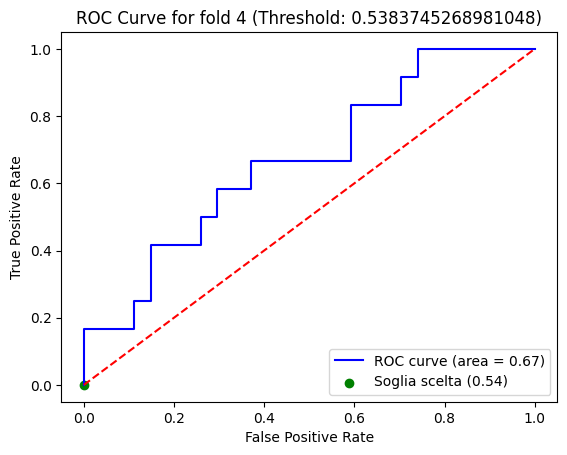

Test Results for fold 4:
Threshold: 0.5383745268981048
F1 Score: 0.5185185185185185
Accuracy: 0.6666666666666666
Confusion Matrix:
[[19  8]
 [ 5  7]]


In [121]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, confusion_matrix

# Funzione per fare predizioni sul test set e visualizzare la ROC con indicazione della soglia
def predici_e_stampa_roc(indice, fold_num, X_test, y_test):
    # Prendi i risultati ordinati in base a F1, ROC AUC e PR AUC
    sorted_results = sorted(grid_results.items(), key=lambda x: (x[1]['avg_f1'], x[1]['avg_roc_auc'], x[1]['avg_pr_auc']), reverse=True)
    
    if indice >= len(sorted_results):
        print("L'indice è fuori dal range di sorted_results.")
        return

    # Prendi la combinazione corrispondente
    params, metrics = sorted_results[indice]
    classifier, selector, num_features = params

    # Trova il fold specifico
    filtered_results = [res for res in results_val if res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features]

    if len(filtered_results) < fold_num:
        print("Il fold specificato non esiste.")
        return

    # Prendi i risultati per il fold specifico
    res = filtered_results[fold_num - 1]  # fold_num è 1-based, quindi sottrai 1 per accedere all'indice corretto
    threshold = res['threshold']  # Usa la soglia che hai trovato sul validation
    model = res['model']  # Usa il modello allenato per quel fold
    selected_features = res['selected_features']  # Prendi le feature selezionate nel fold

    # Riduci il test set alle feature selezionate nel fold di validazione
    X_test_selected = X_test[:, selected_features]  # Applica la selezione delle feature

    # Fai predizioni sul test set ridotto
    y_proba_test = model.predict_proba(X_test_selected)[:, 1]

    # Calcola la ROC curve
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_proba_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Trova il punto corrispondente alla soglia salvata sul validation set
    idx_threshold = (thresholds_test >= threshold).argmax()  # Trova l'indice del punto sulla ROC
    fpr_threshold = fpr_test[idx_threshold]
    tpr_threshold = tpr_test[idx_threshold]

    # Visualizza la ROC curve con la soglia salvata
    plt.figure()
    plt.plot(fpr_test, tpr_test, color='blue', label=f'ROC curve (area = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')

    # Mostra il punto della soglia scelta
    plt.scatter(fpr_threshold, tpr_threshold, color='green', marker='o', label=f'Soglia scelta ({threshold:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for fold {fold_num} (Threshold: {threshold})')
    plt.legend(loc="lower right")
    plt.show()

    # Applica la soglia salvata
    y_pred_test = (y_proba_test >= threshold).astype(int)

    # Stampa le metriche di valutazione sul test set
    print(f"Test Results for fold {fold_num}:")
    print(f"Threshold: {threshold}")
    print(f"F1 Score: {f1_score(y_test, y_pred_test)}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_test)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_test)}")

# Esempio di utilizzo
indice = 0  # Specifica l'indice del risultato ordinato che vuoi utilizzare
fold_num = 4  # Specifica il fold migliore che hai trovato
predici_e_stampa_roc(indice, fold_num, X_test_reduced, y_test)


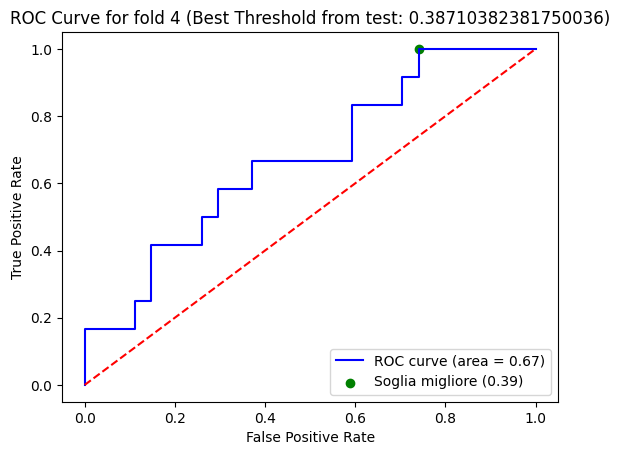

Test Results for fold 4:
Best Threshold (from test): 0.38710382381750036
Best F1 Score: 0.5454545454545454
Accuracy: 0.48717948717948717
Confusion Matrix:
[[ 7 20]
 [ 0 12]]


In [112]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, confusion_matrix

# Funzione per fare predizioni sul test set e scegliere la soglia migliore basata sul test set
def predici_con_soglia_migliore_da_roc(indice, fold_num, X_test, y_test):
    # Prendi i risultati ordinati in base a F1, ROC AUC e PR AUC
    sorted_results = sorted(grid_results.items(), key=lambda x: (x[1]['avg_f1'], x[1]['avg_roc_auc'], x[1]['avg_pr_auc']), reverse=True)
    
    if indice >= len(sorted_results):
        print("L'indice è fuori dal range di sorted_results.")
        return

    # Prendi la combinazione corrispondente
    params, metrics = sorted_results[indice]
    classifier, selector, num_features = params

    # Trova il fold specifico
    filtered_results = [res for res in results_val if res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features]

    if len(filtered_results) < fold_num:
        print("Il fold specificato non esiste.")
        return

    # Prendi i risultati per il fold specifico
    res = filtered_results[fold_num - 1]  # fold_num è 1-based, quindi sottrai 1 per accedere all'indice corretto
    model = res['model']  # Usa il modello allenato per quel fold
    selected_features = res['selected_features']  # Prendi le feature selezionate nel fold

    # Riduci il test set alle feature selezionate nel fold di validazione
    X_test_selected = X_test[:, selected_features]  # Applica la selezione delle feature

    # Fai predizioni sul test set ridotto
    y_proba_test = model.predict_proba(X_test_selected)[:, 1]

    # Calcola la ROC curve per il test set
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_proba_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Ora cerca la soglia migliore tra quelle calcolate con la ROC sul test set
    best_f1_score = -1
    best_threshold_test = 0
    best_fpr_test = 0
    best_tpr_test = 0

    for idx, threshold in enumerate(thresholds_test):
        y_pred_test = (y_proba_test >= threshold).astype(int)
        current_f1 = f1_score(y_test, y_pred_test)
        if current_f1 > best_f1_score:
            best_f1_score = current_f1
            best_threshold_test = threshold
            best_fpr_test = fpr_test[idx]
            best_tpr_test = tpr_test[idx]

    # Visualizza la ROC curve con la nuova soglia
    plt.figure()
    plt.plot(fpr_test, tpr_test, color='blue', label=f'ROC curve (area = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')

    # Mostra il punto della soglia scelta sul test set
    plt.scatter(best_fpr_test, best_tpr_test, color='green', marker='o', label=f'Soglia migliore ({best_threshold_test:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for fold {fold_num} (Best Threshold from test: {best_threshold_test})')
    plt.legend(loc="lower right")
    plt.show()

    # Applica la soglia migliore trovata sul test set
    y_pred_test_best = (y_proba_test >= best_threshold_test).astype(int)

    # Stampa le metriche di valutazione sul test set
    print(f"Test Results for fold {fold_num}:")
    print(f"Best Threshold (from test): {best_threshold_test}")
    print(f"Best F1 Score: {best_f1_score}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_test_best)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_test_best)}")

# Esempio di utilizzo
indice = 0  # Specifica l'indice del risultato ordinato che vuoi utilizzare
fold_num = 4  # Specifica il fold migliore che hai trovato
predici_con_soglia_migliore_da_roc(indice, fold_num, X_test_reduced, y_test)


In [123]:
# Funzione per riallenare il classificatore utilizzando il fold specifico e la threshold trovata
def riallena_classificatore_con_threshold(indice, fold_num, X_train, y_train, X_test, y_test):
    # Prendi i risultati ordinati in base a F1, ROC AUC e PR AUC
    sorted_results = sorted(grid_results.items(), key=lambda x: (x[1]['avg_f1'], x[1]['avg_roc_auc'], x[1]['avg_pr_auc']), reverse=True)
    
    if indice >= len(sorted_results):
        print("L'indice è fuori dal range di sorted_results.")
        return

    # Prendi la combinazione corrispondente dall'indice dato
    params, metrics = sorted_results[indice]
    classifier, selector, num_features = params

    # Trova il fold specifico
    filtered_results = [res for res in results_val if res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features]

    if len(filtered_results) < fold_num:
        print("Il fold specificato non esiste.")
        return

    # Prendi i risultati per il fold specifico
    res = filtered_results[fold_num - 1]  # fold_num è 1-based, quindi sottrai 1 per accedere all'indice corretto
    threshold = res['threshold']  # Usa la soglia che hai trovato sul validation
    selected_features = res['selected_features']  # Prendi le feature selezionate nel fold

    # Inizializza il classificatore corrispondente
    if classifier == 'RandomForest':
        classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif classifier == 'Logistic':
        classi = LogisticRegression()
    elif classifier == 'SVM':
        classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif classifier == 'XgBoost':
        classi = XGBClassifier()
    elif classifier == 'MLP':
        classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
    elif classifier == 'ensemble':
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        logistic_model = LogisticRegression(random_state=42)
        svc_model = SVC(kernel='rbf', probability=True, random_state=42)

        # Crea l'ensemble con VotingClassifier
        classi = VotingClassifier(
            estimators=[
                ('random_forest', rf_model),
                ('logistic', logistic_model),
                ('svc', svc_model)
            ],
            voting='soft'  # 'soft' usa le probabilità di classe, 'hard' usa le predizioni di classe
        )

    # Rialleniamo il classificatore passando il numero di feature selezionato e la threshold
    best_case = classification_method(
        selector, 
        classi, 
        0, 
        X_train,  # Applica la selezione delle feature anche su X_train
        y_train, 
        X_test,  # Applica la selezione delle feature anche su X_test
        y_test, 
        num_features, 
        mode="Val", 
        selected_features=[0], 
        thresholds= np.arange(0.39, 0.6, 0.001)   # Passa la threshold trovata nel fold
    )

    # Stampa i risultati del classificatore riallenato
    print("Metrics from best_case ON THE TEST SET:")
    print(f'Classifier: {classifier} with selector: {selector}')
    print(f"Number of Features: {best_case['num_features']}")
    print(f"Threshold: {metrics['avg_threshold']}")
    print(f"Selected Features: {best_case['selected_features']}")
    print(f"Precision-Recall AUC: {best_case['pr_auc']}")
    print(f"Best Precision: {best_case['best_precision']}")
    print(f"Best Recall: {best_case['best_recall']}")
    print(f"ROC AUC: {best_case['roc_auc']}")
    print(f"F1 Score: {best_case['f1']}")
    print(f"Accuracy: {best_case['accuracy']}")
    print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")

# Esempio di utilizzo
indice = 0  # Specifica l'indice del risultato ordinato che vuoi utilizzare
fold_num = 4  # Specifica il fold migliore che hai trovato

# Riallenare il classificatore con la soglia e il numero di feature del fold specifico
riallena_classificatore_con_threshold(indice, fold_num, X_train_reduced, Y_train, X_test_reduced, y_test)


Metrics from best_case ON THE TEST SET:
Classifier: SVM with selector: p_value
Number of Features: 6
Threshold: 0.4069567607969823
Selected Features: [19 18 12 14  7  0]
Precision-Recall AUC: 0.4001332075444652
Best Precision: 0.3076923076923077
Best Recall: 1.0
ROC AUC: 0.6574074074074074
F1 Score: 0.5384615384615384
Accuracy: 0.6923076923076923
Confusion Matrix: 
[[20  7]
 [ 5  7]]


In [ ]:
n=30
best_3_combinations = sorted_results[:n] ## mostrando le n migliori configurazioni
print(best_3_combinations)
print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_3_combinations, start=1):
    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    print(f"Num_features: {params[2]}")
    print(f"Threshold: {metrics['avg_threshold']}")
    print(f"Performance medie: F1 = {metrics['avg_f1']} (std = {metrics['std_f1']}), "
          f"PR AUC = {metrics['avg_pr_auc']} (std = {metrics['std_pr_auc']}), "
          f"Accuracy = {metrics['avg_accuracy']} (std = {metrics['std_accuracy']})")


    if params[0] == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif params[0] == 'Logistic':
                            classi = LogisticRegression()
    elif params[0] == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif params[0] == 'XgBoost':
                            classi = XGBClassifier()
    elif params[0] == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
    elif params[0] == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)

                            # Crea l'ensemble con VotingClassifier
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'  # 'soft' usa le probabilità di classe, 'hard' usa le predizioni di classe
                                )

   
     
    best_case=classification_method(params[1], classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, params[2], mode="Val", selected_features=[0], thresholds=metrics['avg_threshold'])


    print("Metrics from best_case ON THE TEST SET:")

    print(f"Number of Features: {best_case['num_features']}")
    print(f"Threshold: {metrics['avg_threshold']}")
    print(f"Selected Features: {best_case['selected_features']}")
    print(f"Precision-Recall AUC: {best_case['pr_auc']}")
    print(f"Best Precision: {best_case['best_precision']}")
    print(f"Best Recall: {best_case['best_recall']}")
    print(f"ROC AUC: {best_case['roc_auc']}")
    print(f"F1 Score: {best_case['f1']}")
    print(f"Accuracy: {best_case['accuracy']}")
    print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")
